In [2]:

import os
from imageio import imread
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, Input, add
from tensorflow.keras.optimizers import Adam, SGD

In [4]:
BATCH_SIZE = 8
DATA_X_PATH = 'downgraded/'
DATA_Y_PATH = 'train/'

In [5]:
def get_image_list(path):
    l = os.listdir(path)
    train_list = []
    for f in l:
        if f[-4:] == '.png' or '.jpg':
            train_list.append(f)
    return train_list

In [7]:
train_list = get_image_list('train/')
len(train_list)

300

target_list : 사진을 리스트 형태로 저장

offset : 배치사이즈와 동일한 개념인 것 같다. 1500장의 사진을 배치사이즈만큼 뛰어서 나눈다

In [8]:
def get_image_batch(target_list, offset):            # 1500
    target = target_list[offset:offset+BATCH_SIZE]   # target = 64개 target_list
    batch_x = []                                     # 1batch당 64개씩 들어가있음 즉, epochs 안에 23번 훈련
    batch_y = []
    for t in target:                                    # 64번
        x = cv2.imread(os.path.join(DATA_X_PATH, t))    # 순서대로 파일 읽기
        y = cv2.imread(os.path.join(DATA_Y_PATH, t))
        
        # downgraded 이미지 원래 픽셀로 복원
        x1, x2, x3 = cv2.split(x)
        x1 = cv2.resize(x1, (256, 256), interpolation=cv2.INTER_CUBIC)
        x2 = cv2.resize(x2, (256, 256), interpolation=cv2.INTER_CUBIC)
        x3 = cv2.resize(x3, (256, 256), interpolation=cv2.INTER_CUBIC)
        x = cv2.merge((x1, x2, x3))
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
        batch_x.append(x)
        batch_y.append(y)
    
    # 넘파이 배열로 변형 후 스케일링
    batch_x = np.array(batch_x).astype(float)/255
    batch_y = np.array(batch_y).astype(float)/255  # astype(float)
    return batch_x, batch_y

In [9]:
def image_gen(target_list):
    while True:
        for step in range(len(target_list)//BATCH_SIZE):               # 23번 반복 (1500//64 = 23)
            offset = step*BATCH_SIZE                                   # offset은 각 스텝*64
            batch_x, batch_y = get_image_batch(target_list, offset)
            yield (batch_x, batch_y)

In [10]:
img_list = get_image_list(DATA_X_PATH)             # img_list = 리스트(1500개)
imgs_to_train = len(img_list) *  (7, 3)[0] // 10   # 1050
train_list = img_list[:imgs_to_train]              # (0:1049)
test_list = img_list[imgs_to_train:]               # (1050:1500)

모델링

In [11]:
# model 
input_img = Input(shape=(256, 256, 3))

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(input_img)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(1, (3, 3), padding='same', kernel_initializer='he_normal')(model)
res_img = model

output_img = add([res_img, input_img])

model = Model(input_img, output_img)

컴파일

In [12]:
adam = Adam(learning_rate=0.00005)
sgd = SGD(learning_rate=1e-5, momentum=0.9, decay=1e-5, nesterov=False)
model.compile(adam, loss='mse', metrics=['mse'])

예측

      - 데이터 이미지 표준화 안시킴 -> 이미지규격이 다르면 안돌아감
      - worker=8 이걸로 하려면 threadsafe_iter 사용법을 알아야함

In [13]:
start = time.time()
model.fit(image_gen(train_list), steps_per_epoch=len(train_list) // BATCH_SIZE, 
          validation_data=image_gen(test_list), validation_steps=len(test_list) // BATCH_SIZE, 
          epochs=30, workers=1)
end = time.time()-start
print("걸린 시간 : ", end)
model.save_weights('save_weights.h5')

Epoch 1/30
26/26 [==============================] - 12s 333ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 2/30
26/26 [==============================] - 8s 327ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 3/30
26/26 [==============================] - 8s 322ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/30
26/26 [==============================] - 8s 323ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 5/30
26/26 [==============================] - 8s 323ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 6/30
26/26 [==============================] - 8s 325ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 7/30
26/26 [==============================] - 8s 326ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 8/30
26/26 [==============================] - 8s 311ms/step - loss: 0

예측

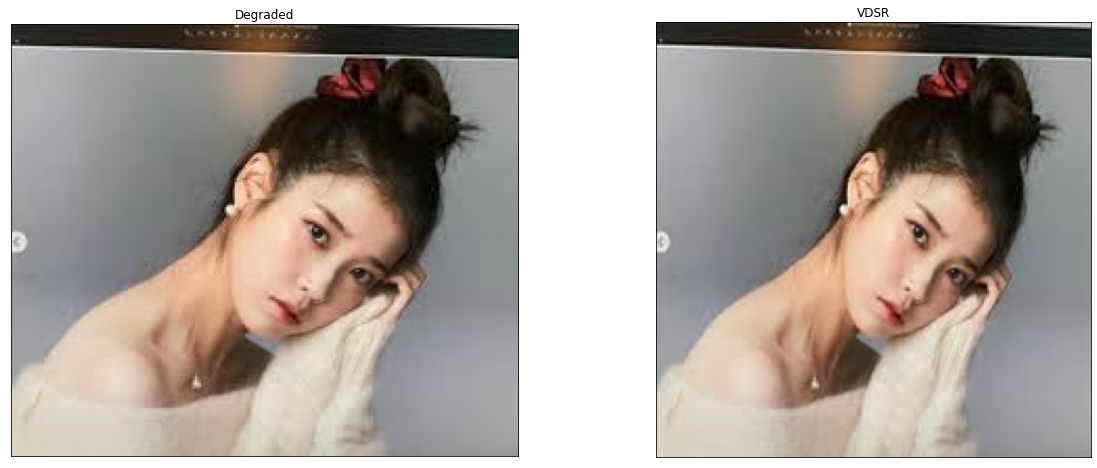

In [31]:
IU = cv2.imread('IU5.jpg')
x1, x2, x3 = cv2.split(IU)
x1 = cv2.resize(x1, (256, 256), interpolation=cv2.INTER_CUBIC)
x2 = cv2.resize(x2, (256, 256), interpolation=cv2.INTER_CUBIC)
x3 = cv2.resize(x3, (256, 256), interpolation=cv2.INTER_CUBIC)
x = cv2.merge((x1, x2, x3))
# img = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
img = np.array(x).astype('float32') / 255
img = img.reshape(1, 256, 256, 3)


pre =  model.predict(img)
pre *= 255
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

pre = pre.reshape(256, 256, 3)
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].imshow(cv2.cvtColor(IU, cv2.COLOR_BGR2RGB))
axs[0].set_title("Degraded")
axs[1].imshow(cv2.cvtColor(pre, cv2.COLOR_BGR2RGB))
axs[1].set_title("VDSR")

# remove the x and y tick marks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])